## Importing All Required Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [27]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [28]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [29]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [30]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [31]:
df1 = df.copy()
df1.set_index('Date', inplace=True)

### Dropping unwanted column

In [32]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)

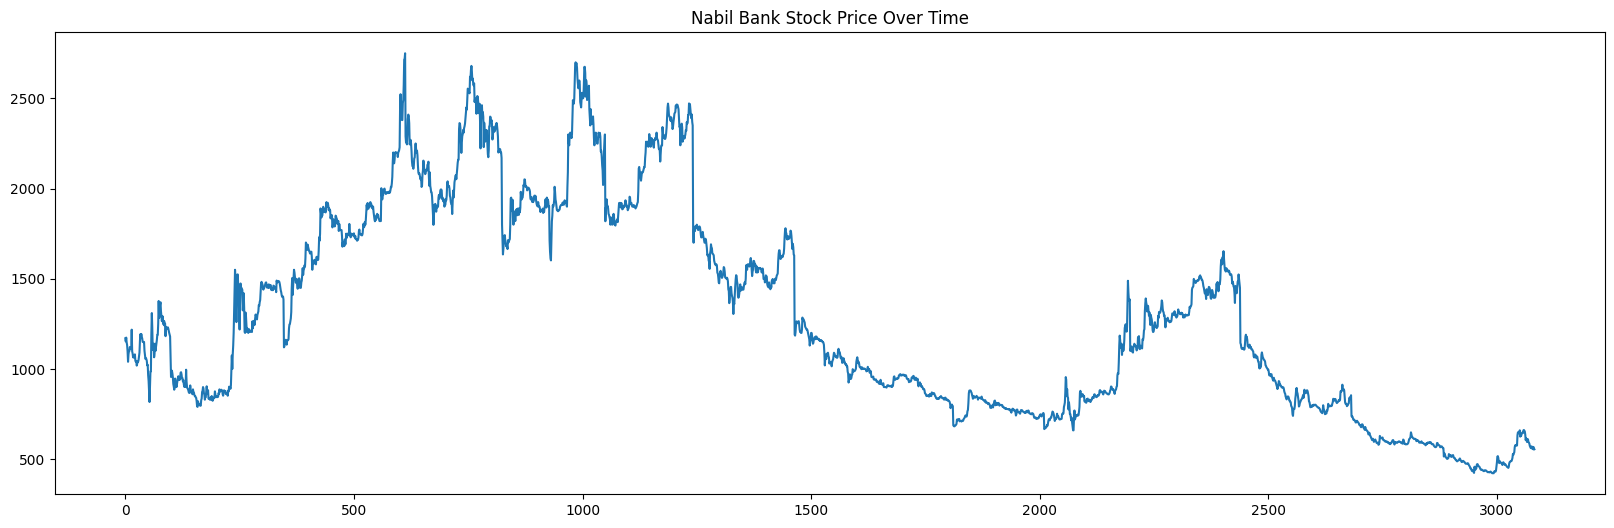

In [34]:
# Visualize the close price
plt.figure(figsize=(20,6))
plt.plot(df['Close'])
plt.title('Nabil Bank Stock Price Over Time')
plt.show()

### Check the data is stationary or not
## ADF test
We are using Augumented Dickey Fuller (ADF) test to eck if the price series is stationary.
The null hypothesis of the ADF test is that the time series is non-stationary. So if the p-value of the test is less than the significance level (0.05) than we can reject the null hypothesisband infer that the tim series is indeed stationary.

In [35]:
# Perform ADF test
result = adfuller(df['Close'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'No. of lags used: {result[2]}')
print(f'Number of observations used: {result[3]}')

ADF Statistic: -1.4270521114095507
p-value: 0.5692405014136024
No. of lags used: 4
Number of observations used: 3078


### Auto-correlation function (ACF)

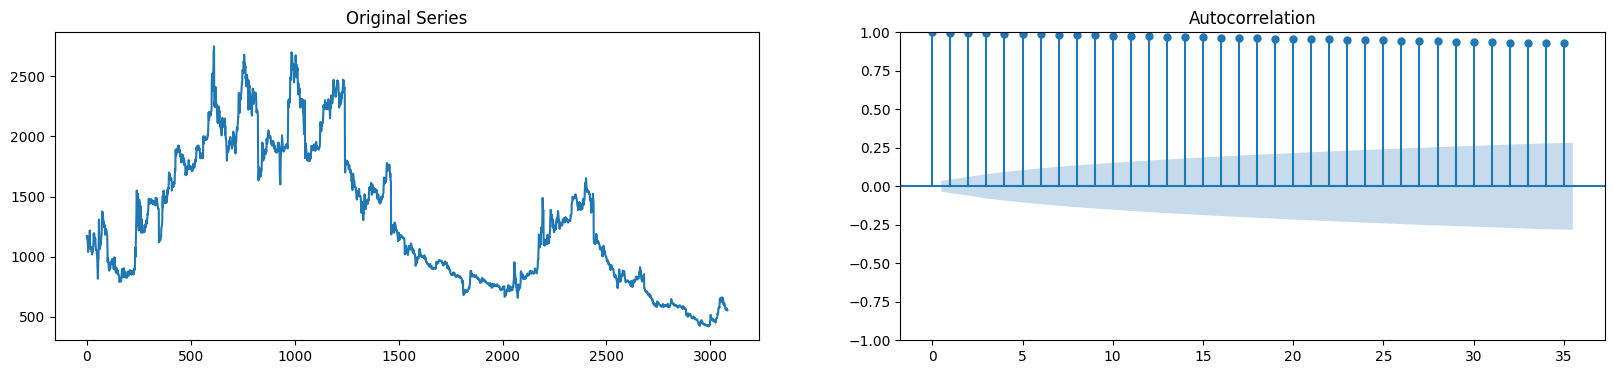

In [36]:
# Plot ACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(df['Close'])
ax1.set_title('Original Series')

plot_acf(df['Close'], ax=ax2);

## d
### Differencing the Data (If Not Stationary)

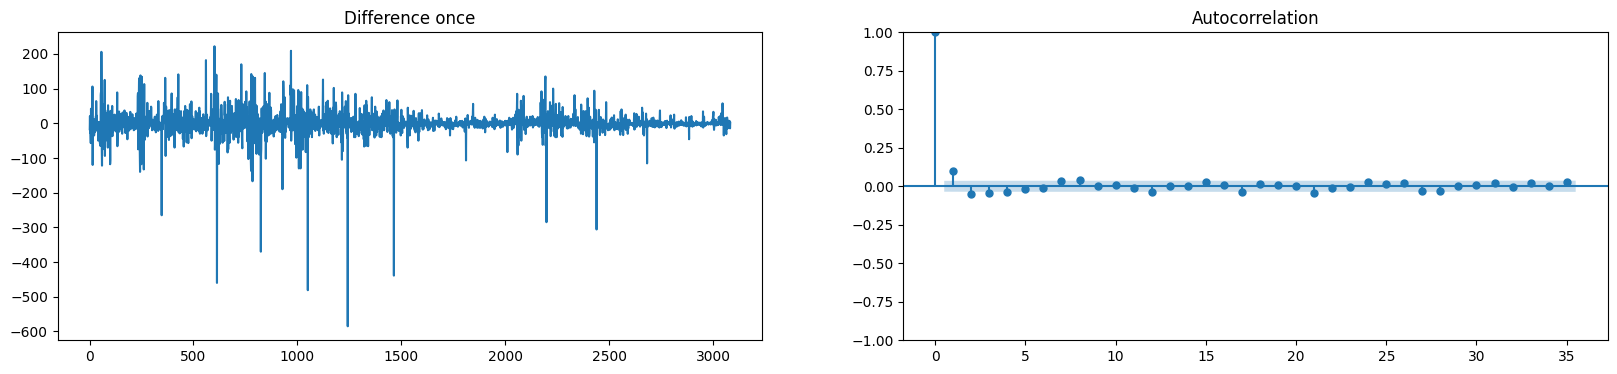

In [37]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference once')

plot_acf(diff, ax=ax2);

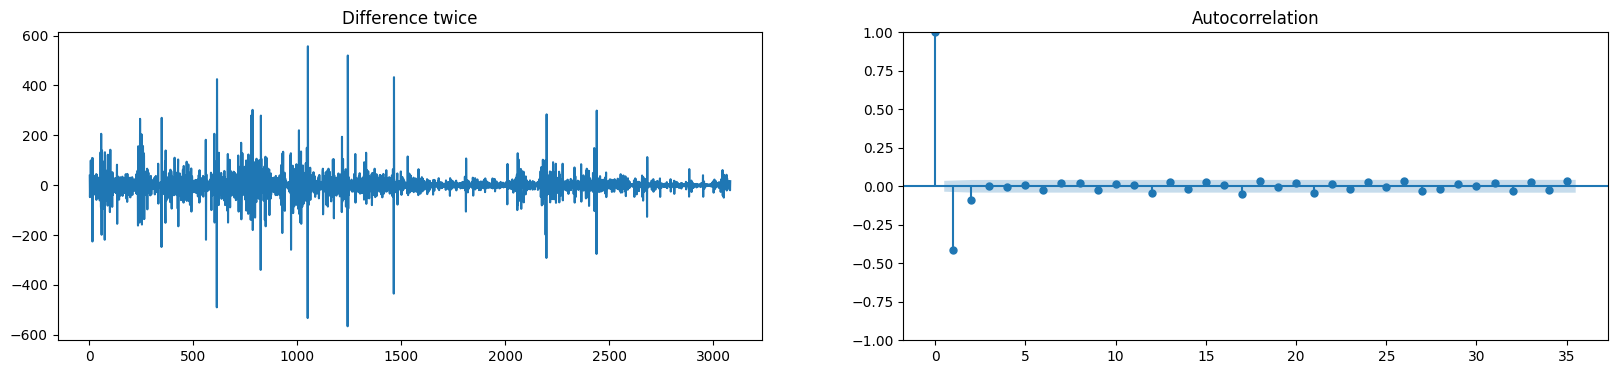

In [38]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference twice')

plot_acf(diff, ax=ax2);

We can use the pmdarima library to get the number of differencing like d required for our model.

In [39]:
ndiffs(df['Close'], test='adf')

1

## p
p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

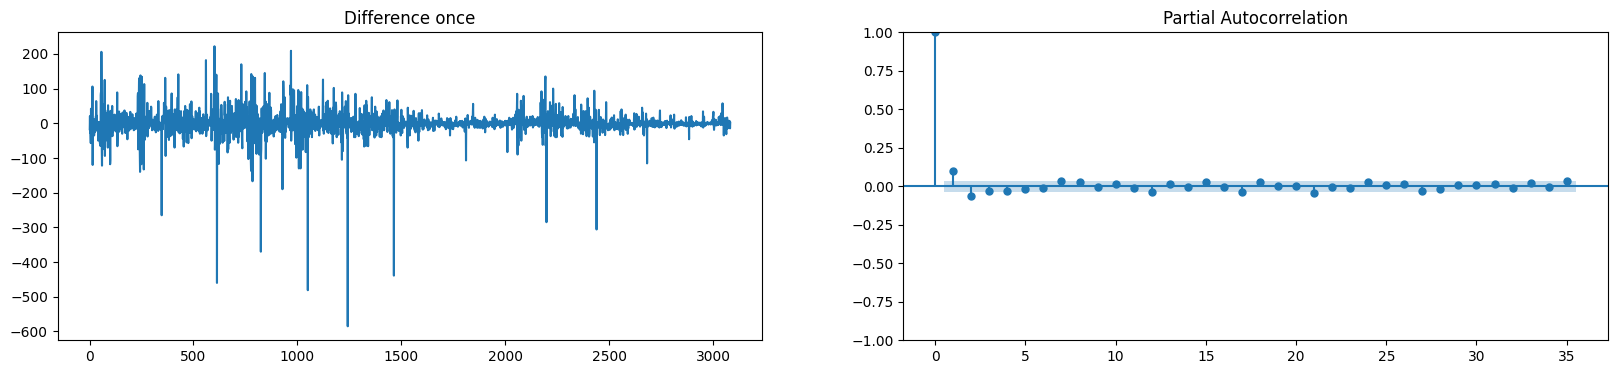

In [40]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

## q
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into ARIMA model.

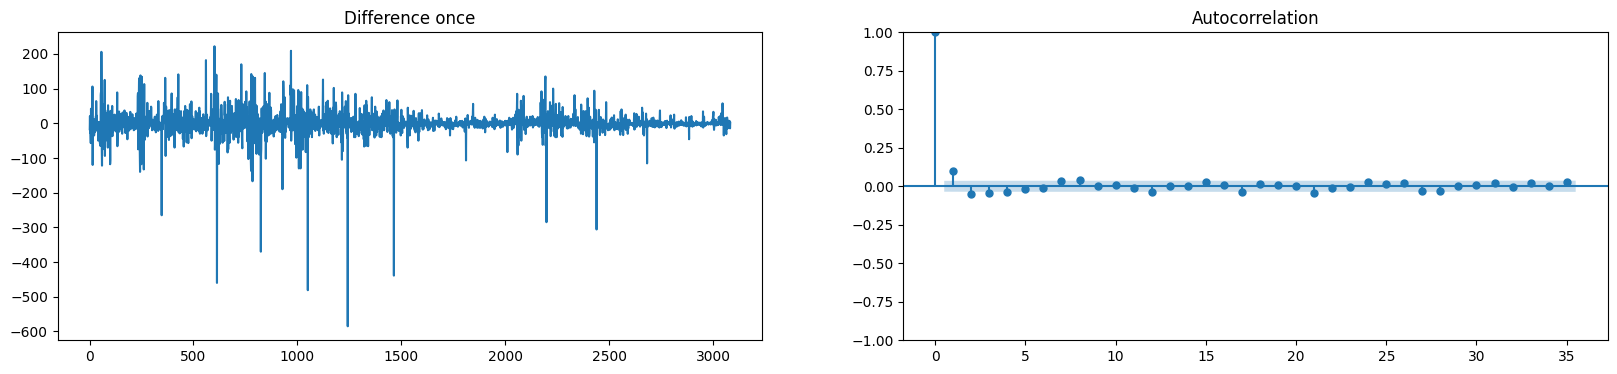

In [41]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

#Splitting the data into train set and test set

In [42]:
y = df['Close']
X = df[['Open', 'High', 'Low', 'Volume']]

In [43]:
# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8
split_point = int(len(df) * split_ratio)

# Training and testing sets for target and features
y_train, y_test = y[:split_point], y[split_point:]
X_train, X_test = X[:split_point], X[split_point:]

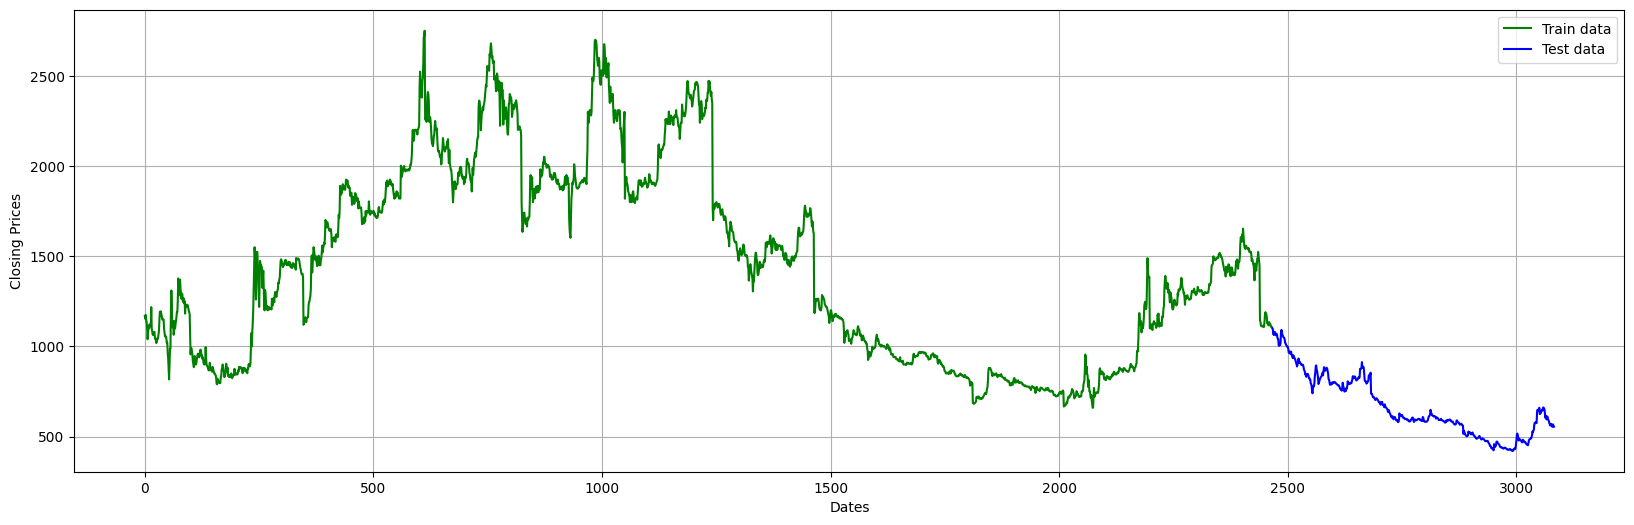

In [44]:
plt.figure(figsize=(20,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend()

### For p, d, q we can use the above method observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30729.592, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30700.381, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30696.581, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30727.690, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30694.518, Time=2.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30685.577, Time=2.96 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30689.853, Time=0.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=30687.486, Time=7.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=30687.409, Time=10.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=30686.707, Time=1.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=30688.460, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=30689.482, Time=2.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=30683.681, Time=2.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30692.595, Time=1.31 sec
 ARIMA(2,1,0)(0,0,

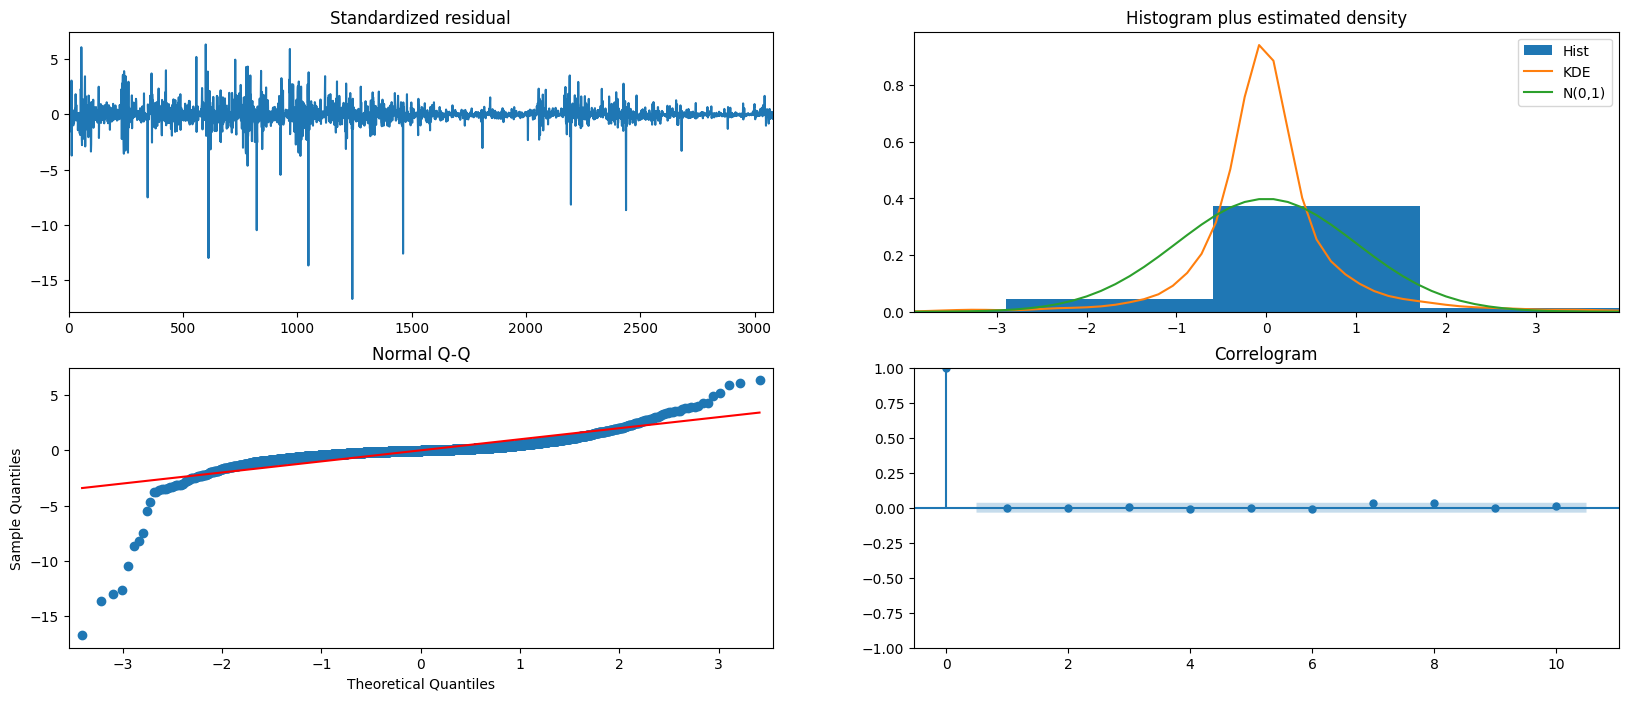

In [45]:
model_autoARIMA = auto_arima(df.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(20,8))
plt.show()

### Now fitting the model

In [46]:
model = SARIMAX(y_train, order=(2, 1, 1), seasonal_order=(2, 1, 1, 12), exog=X_train)
start = time.time()
fitted_model = model.fit(disp=False)
end = time.time()
print(f"Time taken to fit the model: {end - start}")

# Print model summary
print(fitted_model.summary())

Time taken to fit the model: 99.68004989624023
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2466
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood              -10638.164
Date:                            Sun, 24 Nov 2024   AIC                          21298.328
Time:                                    01:13:16   BIC                          21362.184
Sample:                                         0   HQIC                         21321.533
                                           - 2466                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.2453      0.014    -18.002      0.000      -0.272 

In [47]:
forecast = fitted_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Print forecasted values
forecast

,predicted_mean
2466,1092.045812
2467,1088.356350
2468,1079.361649
2469,1069.643827
2470,1073.823607
...,...
3078,332.162501
3079,345.920897
3080,345.277252
3081,338.735267


In [48]:
y_test

,Close
2466,1100.9
2467,1097.1
2468,1070.0
2469,1064.0
2470,1075.0
...,...
3078,556.0
3079,562.0
3080,568.0
3081,553.5


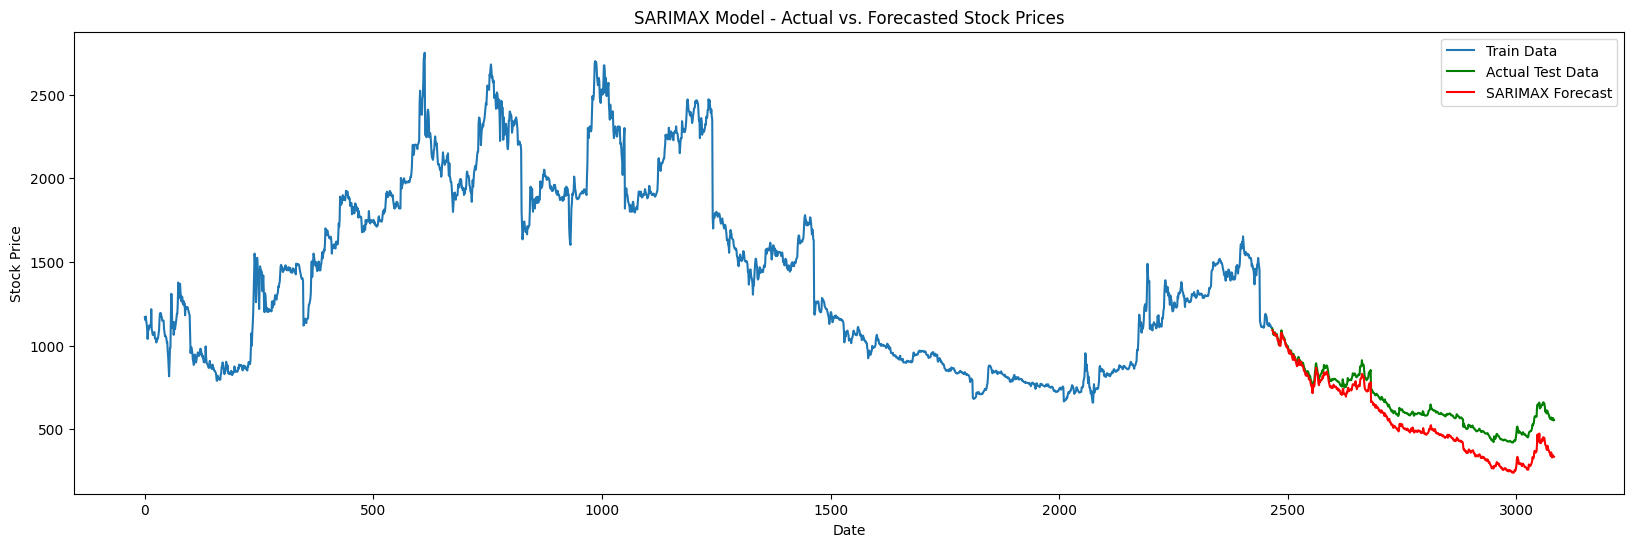

In [49]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(y_train, label='Train Data')
plt.plot(y_test, label='Actual Test Data', color='green')
plt.plot(y_test.index, forecast, label='SARIMAX Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('SARIMAX Model - Actual vs. Forecasted Stock Prices')
plt.legend()
plt.show()

In [50]:
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 14843.968829359581
Root Mean Squared Error: 121.83582736354516
Mean Absolute Error: 104.38810166591465
